In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from ast import Try
import json
from pathlib import Path
from cv2 import randShuffle
import random
import os
import os.path as osp
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from torch.nn.functional import max_pool2d
import matplotlib.pyplot as plt

import numpy as np
import pykitti
import torch
import torchvision
from PIL import Image
from scipy import sparse
from skimage.transform import resize
from torch.utils.data import Dataset
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='../../data/nuscenes-mini/v1.0-mini', verbose=True)
# sample是sample中的文件
# sample_data是sample + sweep中的文件总和
# attribute 代表的是有多少种状态 e.g. 行走的行人，站着的行人
# category 代表的是具体是啥东西 e.g. 成人/小孩
sample_token = nusc.sample[5]["token"]
# 使用token 取出 sample - sample的所有信息的token
my_sample = nusc.get('sample', sample_token)
print(my_sample.keys())   # anns - 有69个

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.522 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
dict_keys(['token', 'timestamp', 'prev', 'next', 'scene_token', 'data', 'anns'])


In [2]:
sample_data_token = my_sample["data"]["CAM_FRONT"]
sd_record = nusc.get('sample_data', sample_data_token)

In [133]:
def map_pointcloud_to_image(nusc,
                            pointsensor_token: str,
                            camera_token: str,
                            sample_rec,
                            nsweeps=3,
                            min_dist: float = 1.0,
                            render_intensity: bool = False,
                            show_lidarseg: bool = False):
    """
    Given a point sensor (lidar/radar) token and camera sample_data token, load pointcloud and map it to the image
    plane.
    :param pointsensor_token: Lidar/radar sample_data token.
    :param camera_token: Camera sample_data token.
    :param min_dist: Distance from the camera below which points are discarded.
    :param render_intensity: Whether to render lidar intensity instead of point depth.
    :param show_lidarseg: Whether to render lidar intensity instead of point depth.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
        or the list is empty, all classes will be displayed.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :return (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
    """

    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)
    pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
    if pointsensor['sensor_modality'] == 'lidar':
        # Ensure that lidar pointcloud is from a keyframe.
        assert pointsensor['is_key_frame'], \
            'Error: Only pointclouds which are keyframes have lidar segmentation labels. Rendering aborted.'
        # pc = LidarPointCloud.from_file(pcl_path)
        # 融合一下lidar信息 # 
        chan="LIDAR_TOP"
        ref_chan = "LIDAR_TOP"
        pc, times = LidarPointCloud.from_file_multisweep(nusc, sample_rec, chan, ref_chan, nsweeps=nsweeps)
    else:
        pc = RadarPointCloud.from_file(pcl_path)
    im = Image.open(osp.join(nusc.dataroot, cam['filename']))

    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]

    if render_intensity:
        assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render intensity for lidar, ' \
                                                            'not %s!' % pointsensor['sensor_modality']
        # Retrieve the color from the intensities.
        # Performs arbitary scaling to achieve more visually pleasing results.
        intensities = pc.points[3, :]
        intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))
        intensities = intensities ** 0.1
        intensities = np.maximum(0, intensities - 0.5)
        coloring = intensities

    else:
        # Retrieve the color from the depth.
        coloring = depths

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]

    return points, coloring, im

def get_depth(nusc, sample, do_flip=False):
    pointsensor_token = sample['data']['LIDAR_TOP']
    camsensor_token = sample['data']['CAM_FRONT']
    pts, depth, img = map_pointcloud_to_image(nusc, pointsensor_token, camsensor_token, my_sample)

    return pts,depth,img

In [134]:
points, coloring, im = get_depth(nusc,my_sample)

In [135]:
points[1,:].max()

898.8907573148208

In [136]:
depth_gt = np.zeros((im.size[0], im.size[1]))
        # 转成坐标形式
pts_int = np.array(points, dtype=int)
depth_gt[pts_int[0,:], pts_int[1,:]] = coloring
depth_gt = np.transpose(depth_gt, (1,0))

In [137]:
c1 = 1/coloring

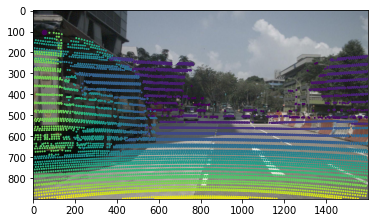

In [141]:
plt.imshow(im)
plt.scatter(points[0,:],points[1,:],c=c1, s=1)
plt.scatter(50,100,c=3, s=20)

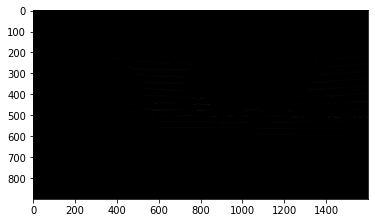

In [142]:

plt.imshow(depth_gt,"gray")

In [140]:
key_sample = my_sample

pointsensor_channel = 'LIDAR_TOP'   # LIDAR_TOP
camera_channel = 'CAM_FRONT'             # CAM_FRONT
key_pointsensor_token = key_sample['data'][pointsensor_channel]   # LIDAR_TOP
key_camera_token = key_sample['data'][camera_channel]         # CAM_FRONT

nusc.get("sample_data",nusc.get("sample_data",key_camera_token)["prev"])

{'token': 'e92333479b9048c88c5db855621f4401',
 'sample_token': '39586f9d59004284a7114a68825e8eec',
 'ego_pose_token': 'e92333479b9048c88c5db855621f4401',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402928012460,
 'fileformat': 'jpg',
 'is_key_frame': False,
 'height': 900,
 'width': 1600,
 'filename': 'sweeps/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928012460.jpg',
 'prev': 'c62818619fbd49ef89c6a311bc509206',
 'next': '4b6870ae200c4b969b91c50a9737f712',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [100]:
nusc.get("sample_data",key_camera_token)

{'token': '4b6870ae200c4b969b91c50a9737f712',
 'sample_token': '39586f9d59004284a7114a68825e8eec',
 'ego_pose_token': '4b6870ae200c4b969b91c50a9737f712',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402928112460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928112460.jpg',
 'prev': 'e92333479b9048c88c5db855621f4401',
 'next': 'cb21f6eaada04b42a1b05d2c7a34e857',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [101]:
sample_token = nusc.sample[1]["token"]
# 使用token 取出 sample - sample的所有信息的token
my_sample = nusc.get('sample', sample_token)


In [102]:
lidar_token = my_sample["data"]["LIDAR_TOP"]
lidar_data = nusc.get("sample_data",lidar_token)

In [103]:
a1 = nusc.get("sample_data",lidar_data["prev"])
a2 = nusc.get("sample_data",a1["prev"])
a3 = nusc.get("sample_data",a2["prev"])
a3

{'token': '97e72e8dd2ac4d07bc0d863f16f2288a',
 'sample_token': '39586f9d59004284a7114a68825e8eec',
 'ego_pose_token': '97e72e8dd2ac4d07bc0d863f16f2288a',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402927997981,
 'fileformat': 'pcd',
 'is_key_frame': False,
 'height': 0,
 'width': 0,
 'filename': 'sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927997981.pcd.bin',
 'prev': '0abbcec5738f46908b6db263ffbad3ae',
 'next': 'f9e41eadc16247e58dc3b9119c607923',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [104]:
key_camData = nusc.get('sample_data', key_camera_token)
key_camData

{'token': '4b6870ae200c4b969b91c50a9737f712',
 'sample_token': '39586f9d59004284a7114a68825e8eec',
 'ego_pose_token': '4b6870ae200c4b969b91c50a9737f712',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402928112460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928112460.jpg',
 'prev': 'e92333479b9048c88c5db855621f4401',
 'next': 'cb21f6eaada04b42a1b05d2c7a34e857',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [105]:
orig_size = tuple((key_camData["height"],key_camData["width"]))
orig_size

(900, 1600)

In [106]:
key_intrinsic_data = nusc.get('calibrated_sensor', key_camData['calibrated_sensor_token'])
key_intrinsic_K = key_intrinsic_data["camera_intrinsic"]
key_intrinsic_K

[[1266.417203046554, 0.0, 816.2670197447984],
 [0.0, 1266.417203046554, 491.50706579294757],
 [0.0, 0.0, 1.0]]

In [107]:
# 第一张
sensor_calib_data = nusc.get('calibrated_sensor', key_camData['calibrated_sensor_token'])
sensor_calib_data

{'token': '1d31c729b073425e8e0202c5c6e66ee1',
 'sensor_token': '725903f5b62f56118f4094b46a4470d8',
 'translation': [1.70079118954, 0.0159456324149, 1.51095763913],
 'rotation': [0.4998015430569128,
  -0.5030316162024876,
  0.4997798114386805,
  -0.49737083824542755],
 'camera_intrinsic': [[1266.417203046554, 0.0, 816.2670197447984],
  [0.0, 1266.417203046554, 491.50706579294757],
  [0.0, 0.0, 1.0]]}

In [108]:
# 上一张
prev_camData = nusc.get('sample_data', key_camData["prev"])
prev_sensor_calib_data = nusc.get('calibrated_sensor', prev_camData['calibrated_sensor_token'])
prev_sensor_calib_data

{'token': '1d31c729b073425e8e0202c5c6e66ee1',
 'sensor_token': '725903f5b62f56118f4094b46a4470d8',
 'translation': [1.70079118954, 0.0159456324149, 1.51095763913],
 'rotation': [0.4998015430569128,
  -0.5030316162024876,
  0.4997798114386805,
  -0.49737083824542755],
 'camera_intrinsic': [[1266.417203046554, 0.0, 816.2670197447984],
  [0.0, 1266.417203046554, 491.50706579294757],
  [0.0, 0.0, 1.0]]}

In [109]:
def get_key_sample(nusc,index,offset):
    '''
    前提: 默认一个scene中至少能取出一个sample
    Return the right key frame for this index (ensure the key frame is centered and there are enough neibor frames)
    Input:
        nusc - nusc dataset
        index - index of sample
        offset - range that neighbor frame reaches
    Return:
        key_sample - the right key frame sample {['token', 'timestamp', 'prev', 'next', 'scene_token', 'data', 'anns']}
    '''
    sample = nusc.sample[index]
    scene = nusc.get("scene",sample["scene_token"])
    nbr_samples = scene["nbr_samples"]
    if nbr_samples < (2*offset+1):
        raise FileNotFoundError("Can't generate one sample in this scene because of too large frame range")

    temp_sample = sample
    prev_count = 0
    next_count = 0

    # ensure prev has enough frames
    for i in range(offset):
        if temp_sample["prev"] == "":
            # 触到prev的边界，需要向后移动offset-i个，来确保prev 有 enough frames
            for j in range(offset-i):
                # 调整到相应位置
                sample = nusc.get('sample', token=sample['next'])
            # 调整完之后应该跳出for循环
            break
        else:
            # 仍有prev, 再向前探索
            temp_sample = nusc.get('sample',temp_sample['prev'])
            prev_count += 1
        # 如果prev时调整了，就无需再next调整
    if prev_count < 4:
        # 向前搜索已经调整过了，无需向后调整
        return sample

    # ensure next has enough frames
    ## 重新校定temp sample到sample一样的位置
    temp_sample = sample
    for i in range(offset):
        if temp_sample["next"] == "":
            # 触到prev的边界，需要向后移动offset-i个，来确保prev 有 enough frames
            for j in range(offset-i):
                # 调整到相应位置
                sample = nusc.get('sample', token=sample['prev'])
            # 调整完之后应该跳出for循环
            break
        else:
            # 仍有next, 再向后探索
            temp_sample = nusc.get('sample',temp_sample['next'])
            next_count += 1
    return sample

In [110]:
def compute_target_intrinsics(key_intrinsic_K, orig_size, target_image_size):
    '''
    每个
    Input: 
        key_intrinsic_K - ndarray 3*3 原始K矩阵
        orig_size - 初始的image02 的原始size - tuple(900,1600)
        target_image_size - (256,512)
    Output:
        intrinsic - 新的K矩阵的4个系数(f_x, f_y, c_x, c_y)
        box - 取原图的中心位置。代表的是4个点的坐标 (w左,h上,w右,h下)
    '''
    # Because of cropping and resizing of the frames, we need to recompute the intrinsics
    P_cam = key_intrinsic_K   # 获取原始K 3*3
    orig_size = orig_size # 2 初始的image02 的原始size
    # 3 我们已经有target image的size

    # 4 通过两个size进行计算，得出intrinsics和box
    r_orig = orig_size[0] / orig_size[1] # 原图 H/W
    r_target = target_image_size[0] / target_image_size[1] # target H/W

    if r_orig >= r_target: # 原图比target 竖直方向更长
        new_height = r_target * orig_size[1]   # new height for 原图
        box = (0, (orig_size[0] - new_height) // 2, orig_size[1], orig_size[0] - (orig_size[0] - new_height) // 2) # 0，新h起点，W，新h终点

        c_x = P_cam[0, 2] / orig_size[1]    # 新K中的tx => 原始的tx/新图的总W
        c_y = (P_cam[1, 2] - (orig_size[0] - new_height) / 2) / new_height  # 新K中的tx => 原始的tx/新图的总W

        rescale = orig_size[1] / target_image_size[1]  # 放缩系数

    else:   # 原图比target 更宽
        new_width = orig_size[0] / r_target
        box = ((orig_size[1] - new_width) // 2, 0, orig_size[1] - (orig_size[1] - new_width) // 2, orig_size[0])  # 新w起点，0，新w终点,h

        c_x = (P_cam[0, 2] - (orig_size[1] - new_width) / 2) / new_width
        c_y = P_cam[1, 2] / orig_size[0]

        rescale = orig_size[0] / target_image_size[0]     # 即800/256

    f_x = P_cam[0, 0] / target_image_size[1] / rescale  # fx * w/target_h = 初始的fx/w
    f_y = P_cam[1, 1] / target_image_size[0] / rescale

    intrinsics = (f_x, f_y, c_x, c_y)

    return intrinsics, box

In [111]:
def preprocess_image(img: Image.Image, crop_box=None):
    '''
    返回target size的image
    '''
    if crop_box:
        # 1.裁剪
        img = img.crop(crop_box)
    if target_image_size:
        # 2.scale
        img = img.resize((target_image_size[1], target_image_size[0]), resample=Image.BILINEAR)
    # if use_color_augmentation:  # default false
    #     # 3.增强
    #     img = color_transform(img)
    # 4. 化成tensor
    image_tensor = torch.tensor(np.array(img).astype(np.float32))
    # 5. 范围scale
    # image_tensor = image_tensor / 255 - .5
    
        # RGB图
    image_tensor = image_tensor.permute(2, 0, 1)      # (3,H,W)
    del img
    return image_tensor

In [112]:
def format_intrinsics(intrinsics, target_image_size):
        '''
        input
            intrinsics - (f_x, f_y, c_x, c_y)
            target_image_size - (256,512)
        output
            intrinsics_mat - 4*4的新K矩阵
        '''
        intrinsics_mat = torch.zeros(4, 4)
        intrinsics_mat[0, 0] = intrinsics[0] * target_image_size[1]
        intrinsics_mat[1, 1] = intrinsics[1] * target_image_size[0]
        intrinsics_mat[0, 2] = intrinsics[2] * target_image_size[1]
        intrinsics_mat[1, 2] = intrinsics[3] * target_image_size[0]
        intrinsics_mat[2, 2] = 1
        intrinsics_mat[3, 3] = 1
        return intrinsics_mat

In [113]:
def preprocess_depth_points(pts, depth, orig_size, key_frame_box, target_image_size):
        '''
        把lidar points warp到
        input
            pts - (3,n1) - coordinates of sparse lidar points
            depth - (n1,) - depth value
            orig_size - (900,1600) - 原图size
            key_frame_box - (新w起点,新h起点,新w终点,新h终点)
            target_image_size - (256,512) - target image size
        Return
            new_pts - (3,n2) - n2≤n1
            new_depth - (n2,)
        '''
        n1 = depth.shape[0]

        # get box area
        w_st, h_st, w_end, h_end= key_frame_box

        if w_st == 0:
            # 原图的h更长, w部分局限, 按照w放缩
            # 900,1600 -> 256,512
            rescale = orig_size[1] / target_image_size[1]
        else:
            # 原图的w更长, h部分局限, 按照h放缩
            # 700,1600 -> 256,512
            rescale = orig_size[0] / target_image_size[0]

        new_pts = []
        new_depth = []

        for i in range(n1):
            xi = pts[0,i]
            yi = pts[1,i]
            if xi<=w_st or xi>=w_end or yi<=h_st or yi>=h_end:
                # not in the box area, throw it out
                continue
            else:
                # keep it and warp
                new_xi = (xi-w_st) / rescale
                new_yi = (yi-h_st) / rescale
                new_pts.append(np.array([new_xi,new_yi,1]))
                new_depth.append(depth[i])
        # change list to array
        new_pts = np.array(new_pts).T
        new_depth = np.array(new_depth)

        return new_pts,new_depth

In [143]:
target_image_size=(900, 1600)
#########################################
key_sample = get_key_sample(nusc,5,1)

# Here we just grab the front camera and the point sensor.
key_pointsensor_token = key_sample['data'][pointsensor_channel]   # lidar data token
key_camera_token = key_sample['data'][camera_channel]    # cam data token

# 在这都是原始的大小
## 1.获取image (未处理的原图)
# keyimg_meta = nusc.get("sample_data",key_pointsensor_token)
# keyimg_filename = keyimg_meta["filename"]
# keyimg_path = osp.join(nusc.dataroot,keyimg_filename)
# keyimg = Image.open(keyimg_path)
#############################  待完成  ##########################################
## 获取depth的lidar points
## 在这由于太稀疏了，所以不使用之前的preprocess了 
pts, depth, keyimg = map_pointcloud_to_image(nusc, key_pointsensor_token, key_camera_token, key_sample, nsweeps=3)
'''
pts - [3,n] - 第一行是height coor, 第二行是width coor, 第三行是1
depth - [n,] - depth value
'''

#######################################################################
## 2. 获取原始intrinsic matrix - K
key_camData = nusc.get('sample_data', key_camera_token)
'''
token, sample_token, ego_posetoken, calibrated_sensor_token, filename, channel, is_key_frame, prev, next - 这指的就是sweep了
'''
key_intrinsic_data = nusc.get('calibrated_sensor', key_camData['calibrated_sensor_token'])
key_intrinsic_K = np.array(key_intrinsic_data["camera_intrinsic"])   # 3*3 K

## 3. 根据target size，预处理原图，K，depth map
### 3.1 获取K新系数，crop box
orig_size = tuple((key_camData["height"],key_camData["width"]))   # (900,1600)
new_key_intrinsics_coff, key_frame_box = compute_target_intrinsics(key_intrinsic_K, orig_size, target_image_size)

### 3.2 预处理原图
keyimg_tensor = preprocess_image(keyimg, key_frame_box)    # (3,H,W)

### 3.3 预处理K
key_K = format_intrinsics(new_key_intrinsics_coff, target_image_size) # 4*4 K

### 3.4 预处理depth map
new_pts, new_depth = preprocess_depth_points(pts, depth, orig_size, key_frame_box, target_image_size)

/Users/handsomeb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  # Remove the CWD from sys.path while we load stuff.


In [144]:
a = np.array(keyimg_tensor.permute([1,2,0]))
# plt.imshow(np.array(keyimg_tensor.permute([1,2,0])))
new_pts.shape

(3, 7966)

Text(0.5, 1.0, 'lidar image')

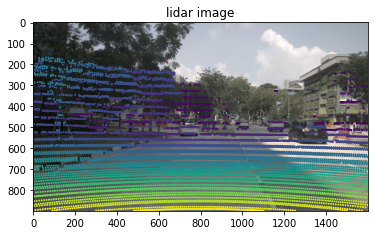

In [145]:
plt.imshow(a.astype(np.int32))
plt.scatter(new_pts[0,:],new_pts[1,:],c=1/new_depth,s=1)
plt.title("lidar image")

In [146]:
new_pts[1,:].max()

898.8903206045117

In [147]:
depth_map = np.zeros(target_image_size)
for i in range(new_depth.shape[0]):
    h = int(new_pts[1,i])
    w = int(new_pts[0,i])
    depth_map[h,w] = 1/new_depth[i]

Text(0.5, 1.0, 'inverse depth map')

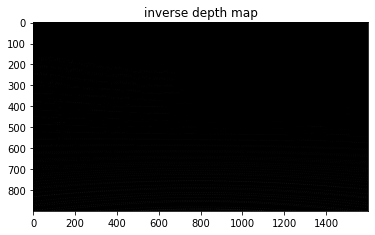

In [148]:
plt.imshow(depth_map,"gray")
plt.title("inverse depth map")

In [126]:
np.sum(depth_map>0)

2882

In [130]:
import cv2
a = cv2.resize(depth_map,(512,256),interpolation=cv2.INTER_NEAREST)

Text(0.5, 1.0, 'inverse depth map')

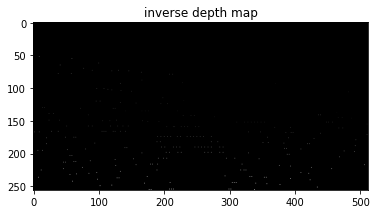

In [131]:
plt.imshow(a,"gray")
plt.title("inverse depth map")

In [132]:
np.sum(a>0)

257

In [36]:
key_ego_pose_token = key_camData["ego_pose_token"]
keyframe_pose = nusc.get("ego_pose", key_ego_pose_token)

In [37]:
keyframe_pose

{'token': 'ddbc1befa70f4b49a0824f63a920676b',
 'timestamp': 1532402930112460,
 'rotation': [0.5859061687572851,
  0.00046748170180213036,
  0.01238901832158085,
  -0.8102840582771244],
 'translation': [404.3748127067429, 1161.3378286421344, 0.0]}

In [42]:
from nuscene_dataset import NuScenesDataset
dataset = NuScenesDataset()
index = 164
# Corresponds to image index 169

batch, depth = dataset.__getitem__(index)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.419 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [46]:
r = batch["keyframe_pose"][:3,:3]
r

tensor([[-9.4722e-01,  3.1987e-01, -2.1304e-02],
        [-3.1995e-01, -9.4744e-01,  1.4294e-04],
        [-2.0139e-02,  6.9517e-03,  9.9977e-01]])

In [52]:
vec = torch.tensor([0,0,1],dtype=torch.float32)
vec

tensor([0., 0., 1.])

In [54]:
s = r@vec

In [55]:
torch.norm(s)

tensor(1.)